In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

Downloaded modsim.py


In [2]:
# import functions from modsim

from modsim import *

In [3]:
download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'glucose_insulin.csv')

Downloaded glucose_insulin.csv


In [4]:
from pandas import read_csv

data = read_csv('glucose_insulin.csv', index_col='time');

In [5]:
G0 = 270
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05

In [6]:
params = G0, k1, k2, k3

In [7]:
def make_system(params, data):
    G0, k1, k2, k3 = params

    t_0 = data.index[0]
    t_end = data.index[-1]

    Gb = data.glucose[t_0]
    Ib = data.insulin[t_0]
    I = interpolate(data.insulin)

    init = State(G=G0, X=0)

    return System(init=init, params=params,
                  Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=2)

In [8]:
system = make_system(params, data)

In [9]:
def update_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt

    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X

    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

In [10]:
update_func(system.t_0, system.init, system)

G    262.88
X      0.00
Name: state, dtype: float64

In [11]:
def run_simulation(system, update_func):
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)

    frame = TimeFrame(index=t_array,
                      columns=system.init.index)
    frame.iloc[0] = system.init

    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)

    return frame

In [12]:
results = run_simulation(system, update_func)

In [13]:
results.head()

,G,X
0.0,270.000000,0.000000
2.0,262.880000,0.000000
4.0,256.044800,0.000450
6.0,249.252568,0.004002
8.0,240.967447,0.006062


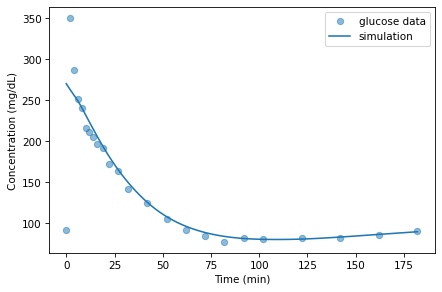

In [14]:
data.glucose.plot(style='o', alpha=0.5, label='glucose data')
results.G.plot(style='-', color='C0', label='simulation')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

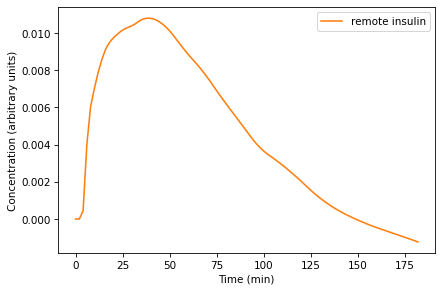

In [15]:
results.X.plot(color='C1', label='remote insulin')

decorate(xlabel='Time (min)',
         ylabel='Concentration (arbitrary units)')

In [16]:
def slope_func(t, state, system):
    G, X = state
    G0, k1, k2, k3 = system.params
    I, Ib, Gb = system.I, system.Ib, system.Gb

    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X

    return dGdt, dXdt

In [17]:
results2, details = run_solve_ivp(system, slope_func,
                                  t_eval=results.index)

In [18]:
details.success

True

In [19]:
details.message

'The solver successfully reached the end of the integration interval.'

In [20]:
results2.head()

,G,X
0.0,270.000000,0.000000
2.0,262.980942,0.000240
4.0,255.683455,0.002525
6.0,247.315442,0.005174
8.0,238.271851,0.006602


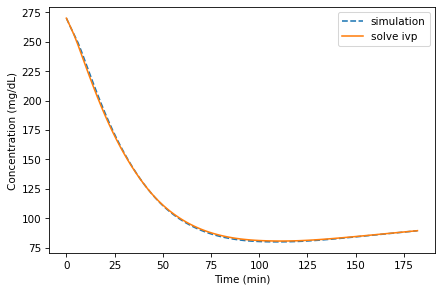

In [21]:
results.G.plot(style='--', label='simulation')
results2.G.plot(style='-', label='solve ivp')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [22]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100

In [23]:
percent_diff.abs().describe()

count    92.000000
mean      0.649121
std       0.392903
min       0.000000
25%       0.274854
50%       0.684262
75%       1.009868
max       1.278168
Name: G, dtype: float64

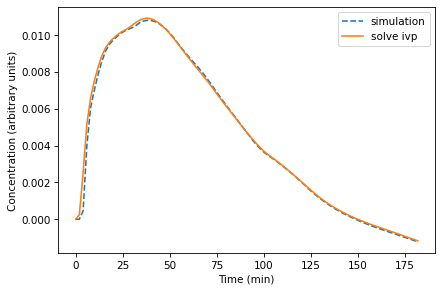

In [24]:
results.X.plot(style='--', label='simulation')
results2.X.plot(style='-', label='solve ivp')

decorate(xlabel='Time (min)',
         ylabel='Concentration (arbitrary units)')

In [25]:
diff = results.G - results2.X
percent_diff = diff / results2.X * 100
percent_diff.abs().describe()

count    9.200000e+01
mean              inf
std               NaN
min      1.095267e+06
25%      1.362916e+06
50%      2.442010e+06
75%      9.517750e+06
max               inf
dtype: float64

### Exercise 1



In [26]:
system3 = system.set(dt = 1)
results3 = run_simulation(system3, update_func)

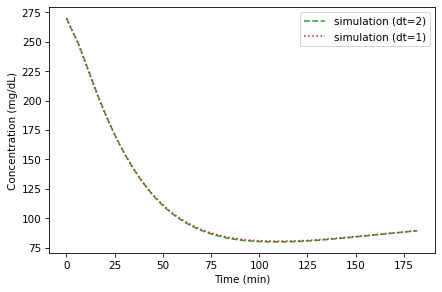

In [27]:
results.G.plot(style='C2--', label='simulation (dt=2)')
results3.G.plot(style='C3:', label='simulation (dt=1)')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

In [28]:
diff = results.G - results3.G
percent_diff = diff / results3.G * 100
percent_diff.abs().describe()

count    92.000000
mean      0.527015
std       0.291531
min       0.000000
25%       0.292193
50%       0.505702
75%       0.801698
max       0.970760
Name: G, dtype: float64